# 5.4.4 Regularizing your model

### *Underfitting and overfitting*

In all three examples in the previous chapter—predicting movie reviews, topic classification, and house-price regression—the performance of the model on the held-out validation data always peaked after a few epochs and then began to degrade: the model quickly started to *overfit* to the training data. Overfitting happens in every machine-learning problem. Learning how to deal with overfitting is essential to mastering machine learning.

The fundamental issue in machine learning is the tension between optimization and generalization. *Optimization* refers to the process of adjusting a model to get the best performance possible on the training data (the learning in machine learning), whereas *generalization* refers to how well the trained model performs on data it has never seen before. The goal of the game is to get good generalization, of course, but you don’t control generalization; you can only adjust the model based on its training data.

At the beginning of training, optimization and generalization are correlated: the lower the loss on training data, the lower the loss on test data. While this is happening, your model is said to be *underfit*: there is still progress to be made; the network hasn’t yet modeled all relevant patterns in the training data. But after a certain number of
iterations on the training data, generalization stops improving, and validation metrics stall and then begin to degrade: the model is starting to overfit. That is, it’s beginning to learn patterns that are specific to the training data but that are misleading or irrelevant when it comes to new data.

To prevent a model from learning misleading or irrelevant patterns found in the training data, *the best solution is to get more training data*. A model trained on more data will naturally generalize better. When that isn’t possible, the next-best solution is to modulate the quantity of information that your model is allowed to store or to add constraints on what information it’s allowed to store. If a network can only afford to
memorize a small number of patterns, the optimization process will force it to focus on the most prominent patterns, which have a better chance of generalizing well.


The processing of fighting overfitting this way is called regularization. Let’s review some of the most common regularization techniques and apply them in
practice to improve the movie-classification model.

## 5.4.4.1 Reducing the network's size

The simplest way to prevent overfitting is to reduce the size of the model: the number of learnable parameters in the model (which is determined by the number of layers and the number of units per layer). In deep learning, the number of learnable parameters in a model is often referred to as the model’s *capacity*. Intuitively, a model with more parameters has more *memorization* capacity and therefore can easily learn a perfect dictionary-like mapping between training samples and their targets—a mapping without any generalization power.  For instance, a model with 500,000 binary parameters could easily be made to learn the class of every digit in the MNIST training set: we’d need only 10 binary parameters for each of the 50,000 digits. But such a model would be useless for classifying new digit samples.

<div class="alert alert-block alert-warning">
 Always keep this in mind: deeplearning models tend to be good at fitting to the training data, but the real challenge is generalization, not fitting.
</div>

 On the other hand, if the network has limited memorization resources, it won’t be able to learn this mapping as easily; thus, in order to minimize its loss, it will have to resort to learning compressed representations that have predictive power regarding the targets—precisely the type of representations we’re interested in. At the same time, keep in mind that you should use models that have enough parameters that they don’t underfit: your model shouldn’t be starved for memorization resources. There is a compromise to be found between *too much capacity* and *not enough capacity*.
 
 Unfortunately, there is no magical formula to determine the right number of layers or the right size for each layer. You must evaluate an array of different architectures (on your validation set, not on your test set, of course) in order to find the correct model size for your data. The general workflow to find an appropriate model size is to start with relatively few layers and parameters, and increase the size of the layers or add new layers until you see diminishing returns with regard to validation loss.
 
 Let’s try this on the movie-review classification network.

In [1]:
from tensorflow.keras.datasets import imdb

(train_data, train_labels), _ = imdb.load_data(num_words=10000)

import numpy as np
def vectorize_sequences(sequences, dimension=10000):
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.
    return results
train_data = vectorize_sequences(train_data)

# train_labels = np.asarray(train_labels).astype('float32')

### *Original model*

In [2]:
from tensorflow import keras
from tensorflow.keras import layers

original_model = keras.Sequential([
    layers.Dense(16, activation='relu'),
    layers.Dense(16, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

original_model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])

original_history = original_model.fit(train_data, train_labels, epochs=20, batch_size=512, validation_split=0.4, verbose=0)

### *Version of the model with lower capacity*

In [3]:
smaller_model = keras.Sequential([
    layers.Dense(4, activation='relu'),
    layers.Dense(4, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

smaller_model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])

smaller_history = smaller_model.fit(train_data, train_labels, epochs=20, batch_size=512, validation_split=0.4, verbose=0)

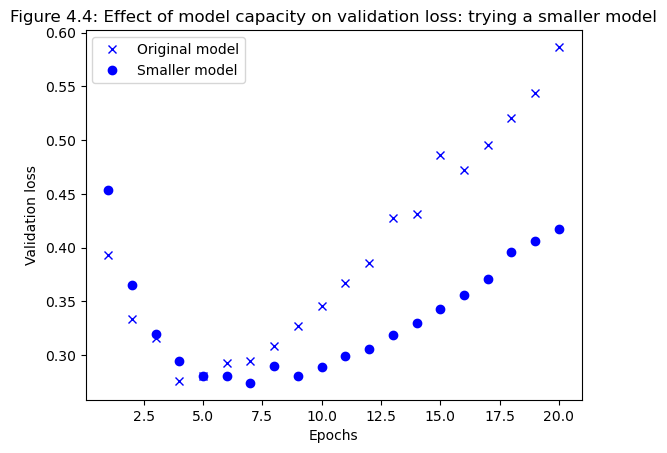

In [4]:
import matplotlib.pyplot as plt

o_val_loss_values = original_history.history['val_loss']
s_val_loss_values = smaller_history.history['val_loss']
epochs = range(1, len(o_val_loss_values) + 1)

plt.plot(epochs, o_val_loss_values, 'bx', label='Original model')
plt.plot(epochs, s_val_loss_values, 'bo', label='Smaller model')
plt.title('Figure 4.4: Effect of model capacity on validation loss: trying a smaller model')
plt.xlabel('Epochs')
plt.ylabel('Validation loss')
plt.legend()

plt.show()

As you can see, the smaller network starts overfitting later than the reference network, and its performance degrades more slowly once it starts overfitting.

 Now, for kicks, let’s add to this benchmark a network that has much more capacity—far more than the problem warrants.
 
### *Version of the model with higher capacity*

In [5]:
larger_model = keras.Sequential([
    layers.Dense(512, activation='relu'),
    layers.Dense(512, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

larger_model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])

larger_history = larger_model.fit(train_data, train_labels, epochs=20, batch_size=512, validation_split=0.4, verbose=0)

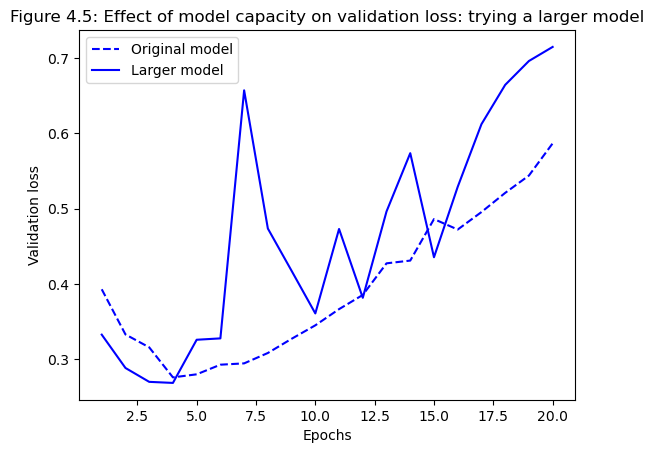

In [10]:
o_val_loss_values = original_history.history['val_loss']
b_val_loss_values = larger_history.history['val_loss']
epochs = range(1, len(o_val_loss_values) + 1)

plt.plot(epochs, o_val_loss_values, 'b--', label='Original model')
plt.plot(epochs, b_val_loss_values, 'b', label='Larger model')
plt.title('Figure 4.5: Effect of model capacity on validation loss: trying a larger model')
plt.xlabel('Epochs')
plt.ylabel('Validation loss')
plt.legend()

plt.show()

The bigger network starts overfitting almost immediately, after just one epoch, and it overfits much more severely. Its validation loss is also noisier.

 Meanwhile, figure 4.6 shows the training losses for the two networks. As you can see, the bigger network gets its training loss near zero very quickly. The more capacity the network has, the more quickly it can model the training data (resulting in a low training loss), but the more susceptible it is to overfitting (resulting in a large difference between the training and validation loss). 

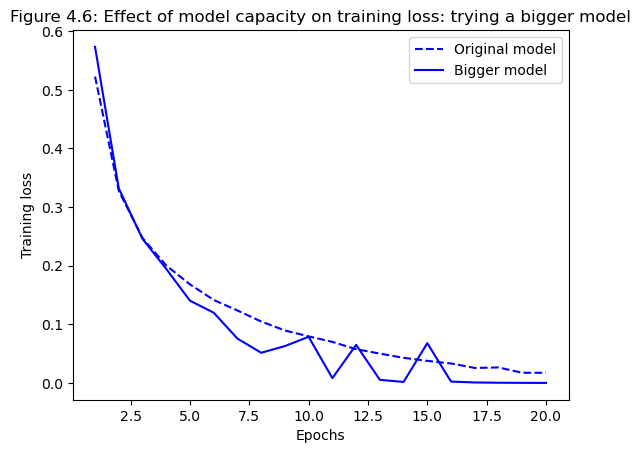

In [12]:
o_loss_values = original_history.history['loss']
b_loss_values = larger_history.history['loss']
epochs = range(1, len(o_loss_values) + 1)

plt.plot(epochs, o_loss_values, 'b--', label='Original model')
plt.plot(epochs, b_loss_values, 'b', label='Bigger model')
plt.title('Figure 4.6: Effect of model capacity on training loss: trying a bigger model')
plt.xlabel('Epochs')
plt.ylabel('Training loss')
plt.legend()

plt.show()

## 5.4.4.2 Adding weight regularization

You may be familiar with the principle of *Occam’s razor*: given two explanations for something, the explanation most likely to be correct is the simplest one—the one that makes fewer assumptions. This idea also applies to the models learned by neural networks: given some training data and a network architecture, multiple sets of weight values (multiple *models*) could explain the data. Simpler models are less likely to overfit than complex ones.

A *simple model* in this context is a model where the distribution of parameter values has less entropy (or a model with fewer parameters, as you saw in the previous section). Thus a common way to mitigate overfitting is to put constraints on the complexity of a network by forcing its weights to take only small values, which makes the
distribution of weight values more *regular*. This is called *weight regularization*, and it’s done by adding to the loss function of the network a *cost* associated with having large weights. This cost comes in two flavors:
- *L1 regularization*—The cost added is proportional to the *absolute value of the weight coefficients* (the *L1 norm* of the weights).
- *L2 regularization*—The cost added is proportional to the *square of the value of the weight coefficients* (the *L2 norm* of the weights). L2 regularization is also called *weight decay* in the context of neural networks. Don’t let the different name confuse you: weight decay is mathematically the same as L2 regularization.

In Keras, weight regularization is added by passing weight regularizer instances to layers as keyword arguments. Let’s add L2 weight regularization to the movie-review classification network.

### *Adding L2 weight regularization to the model*

In [13]:
from tensorflow.keras import regularizers

l2_model = keras.Sequential([
    layers.Dense(16, kernel_regularizer=regularizers.l2(0.002), activation='relu'),
    layers.Dense(16, kernel_regularizer=regularizers.l2(0.002), activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

l2_model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])

l2_history = l2_model.fit(train_data, train_labels, epochs=20, batch_size=512, validation_split=0.4, verbose=0)

`l2(0.002)` means every coefficient in the weight matrix of the layer will add `0.002 * weight_coefficient_value` to the total loss of the network. Note that because this penalty is only *added at training time*, the loss for this network will be much higher at training than at test time.
 
 Figure 4.7 shows the impact of the L2 regularization penalty. As you can see, the model with L2 regularization has become much more resistant to overfitting than the reference model, even though both models have the same number of parameters.

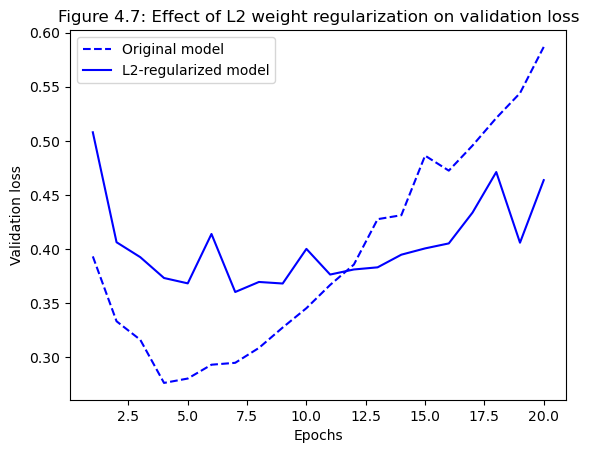

In [15]:
o_val_loss_values = original_history.history['val_loss']
l2_val_loss_values = l2_history.history['val_loss']
epochs = range(1, len(o_val_loss_values) + 1)

plt.plot(epochs, o_val_loss_values, 'b--', label='Original model')
plt.plot(epochs, l2_val_loss_values, 'b', label='L2-regularized model')
plt.title('Figure 4.7: Effect of L2 weight regularization on validation loss')
plt.xlabel('Epochs')
plt.ylabel('Validation loss')
plt.legend()

plt.show()

### *Different weight regularizers available in Keras*
*L1 regularization*

*Simultaneous L1 and L2 regularization*

### *Which regularizer to choose?*

*[How to choose the appropriate regularizer](https://github.com/christianversloot/machine-learning-articles/blob/main/which-regularizer-do-i-need-for-training-my-neural-network.md)*

## 5.4.4.3 Adding dropout

*Dropout* is one of the most effective and most commonly used regularization techniques for neural networks, developed by Geoff Hinton and his students at the University of Toronto. Dropout, applied to a layer, consists of randomly *dropping out* (setting to zero) a number of output features of the layer during training. Let’s say a given layer would normally return a vector [0.2, 0.5, 1.3, 0.8, 1.1] for a given input
sample during training. After applying dropout, this vector will have a few zero entries distributed at random: for example, [0, 0.5, 1.3, 0, 1.1]. The *dropout rate* is the fraction of the features that are zeroed out; it’s usually set between 0.2 and 0.5. At test time, no units are dropped out; instead, the layer’s output values are scaled down by a factor equal to the dropout rate, to balance for the fact that more units are active than at training time.

This technique may seem strange and arbitrary. Why would this help reduce overfitting? Hinton says he was inspired by, among other things, a fraud-prevention mechanism used by banks. In his own words, “I went to my bank. The tellers kept changing
and I asked one of them why. He said he didn’t know but they got moved around a lot. I figured it must be because it would require cooperation between employees to successfully defraud the bank. This made me realize that randomly removing a different
subset of neurons on each example would prevent conspiracies and thus reduce overfitting.” The core idea is that introducing noise in the output values of a layer can break up happenstance patterns that aren’t significant (what Hinton refers to as *conspiracies*), which the network will start memorizing if no noise is present.
 
 In Keras, you can introduce dropout in a network via the `Dropout` layer, which is applied to the output of the layer right before it:

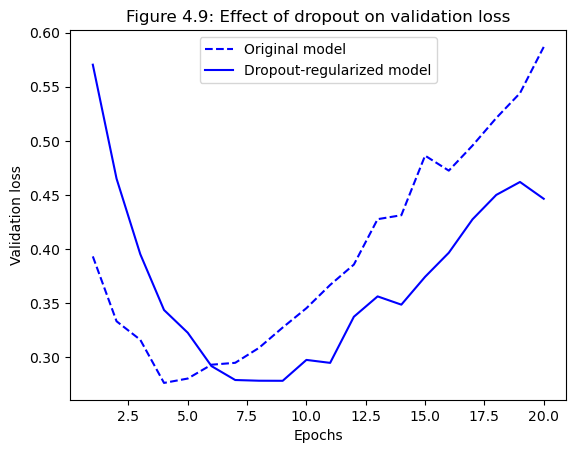

In [17]:
dropout_model = keras.Sequential([
    layers.Dense(16, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(16, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

dropout_model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])

dropout_history = dropout_model.fit(train_data, train_labels, epochs=20, batch_size=512, validation_split=0.4, verbose=0)


o_val_loss_values = original_history.history['val_loss']
dropout_val_loss_values = dropout_history.history['val_loss']
epochs = range(1, len(o_val_loss_values) + 1)

plt.plot(epochs, o_val_loss_values, 'b--', label='Original model')
plt.plot(epochs, dropout_val_loss_values, 'b', label='Dropout-regularized model')
plt.title('Figure 4.9: Effect of dropout on validation loss')
plt.xlabel('Epochs')
plt.ylabel('Validation loss')
plt.legend()

plt.show()

<div class="alert alert-block alert-info">
To recap, these are the most common ways to prevent overfitting in neural networks:
    <ul>
        <li>Get more training data, or better training data.</li>
        <li>Develop better features.</li>
        <li>Reduce the capacity of the network.</li>
        <li>Add weight regularization (for smaller model).</li>
        <li>Add dropout.</li>
    </ul>
</div>